# 1. Import Modules

In [2]:
import requests
import os
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import datetime
from dateutil.relativedelta import relativedelta
import datetime
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import GridSearchCV

# 2. Retrieve and Read Data

In [3]:
#Add API KEY
#url = 'https://www.alphavantage.co/query?function=SUGAR&interval=monthly&datatype=csv&apikey=  ****   '
#
#df = pd.read_csv(url)

In [4]:
df = pd.read_csv('sugar', index_col = 'Unnamed: 0')

# 3. EDA

In [5]:
print(df)

      timestamp             value
0    2023-03-01  20.9617391304348
1    2023-02-01           21.4035
2    2023-01-01  19.9431818181818
3    2022-12-01            20.065
4    2022-11-01  19.4059090909091
..          ...               ...
514  1980-05-01                 .
515  1980-04-01                 .
516  1980-03-01                 .
517  1980-02-01                 .
518  1980-01-01                 .

[519 rows x 2 columns]


Two columns, timestamp and value. Timestamp is from 1980-01-01 - 2023-02-01 in 1 month increments. 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  519 non-null    int64 
 1   timestamp   519 non-null    object
 2   value       519 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.3+ KB
None


both stored as object type, 519 entries

In [6]:
print(df.value.describe())

count     519
unique    398
top         .
freq      120
Name: value, dtype: object


Appears to be 120 values stored as '.'

In [7]:
df= df.rename(columns={'timestamp':'date'})

In [8]:
print(df.date.duplicated().value_counts())

False    519
Name: date, dtype: int64


No dates are duplicated

In [9]:
df = df.set_index('date')
pd.to_datetime(df.index)
df.sort_index(ascending=True, inplace=True)

Set index to date, and sort ascending


In [10]:
print(df.head())

           value
date            
1980-01-01     .
1980-02-01     .
1980-03-01     .
1980-04-01     .
1980-05-01     .


In [11]:
df.value.replace('.', np.nan, inplace=True)
df.value = df.value.astype('float')

Replace '.' with null values, change the value type from object to flaot

In [12]:
print(df[df.value.isnull()])

            value
date             
1980-01-01    NaN
1980-02-01    NaN
1980-03-01    NaN
1980-04-01    NaN
1980-05-01    NaN
...           ...
1989-08-01    NaN
1989-09-01    NaN
1989-10-01    NaN
1989-11-01    NaN
1989-12-01    NaN

[120 rows x 1 columns]


In [13]:
df.dropna(inplace=True)

Dropping null values, as they are the oldest entries. Depending on the analysis we will want to weight toward newer entries 

In [14]:
print(df.head())

                value
date                 
1990-01-01  14.200001
1990-02-01  14.650002
1990-03-01  15.310001
1990-04-01  15.240002
1990-05-01  14.619999


In [15]:
print(df.value.describe())

count    399.000000
mean      13.137825
std        5.125401
min        5.111200
25%        9.352386
50%       12.061905
75%       16.509969
max       29.736842
Name: value, dtype: float64


Quick overview of some summary statistics. 

# 4. Visualise

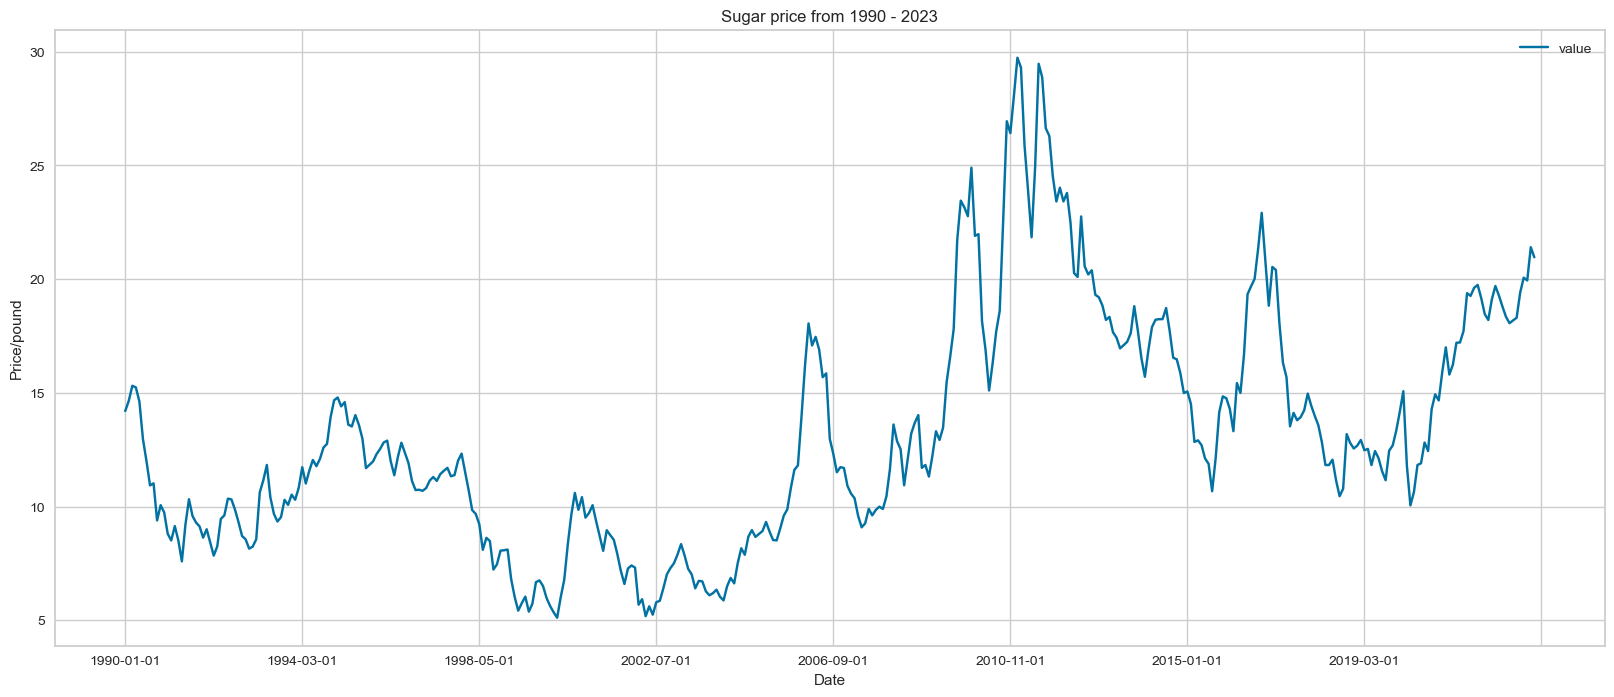

In [16]:
df.plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price from 1990 - 2023')
plt.show()

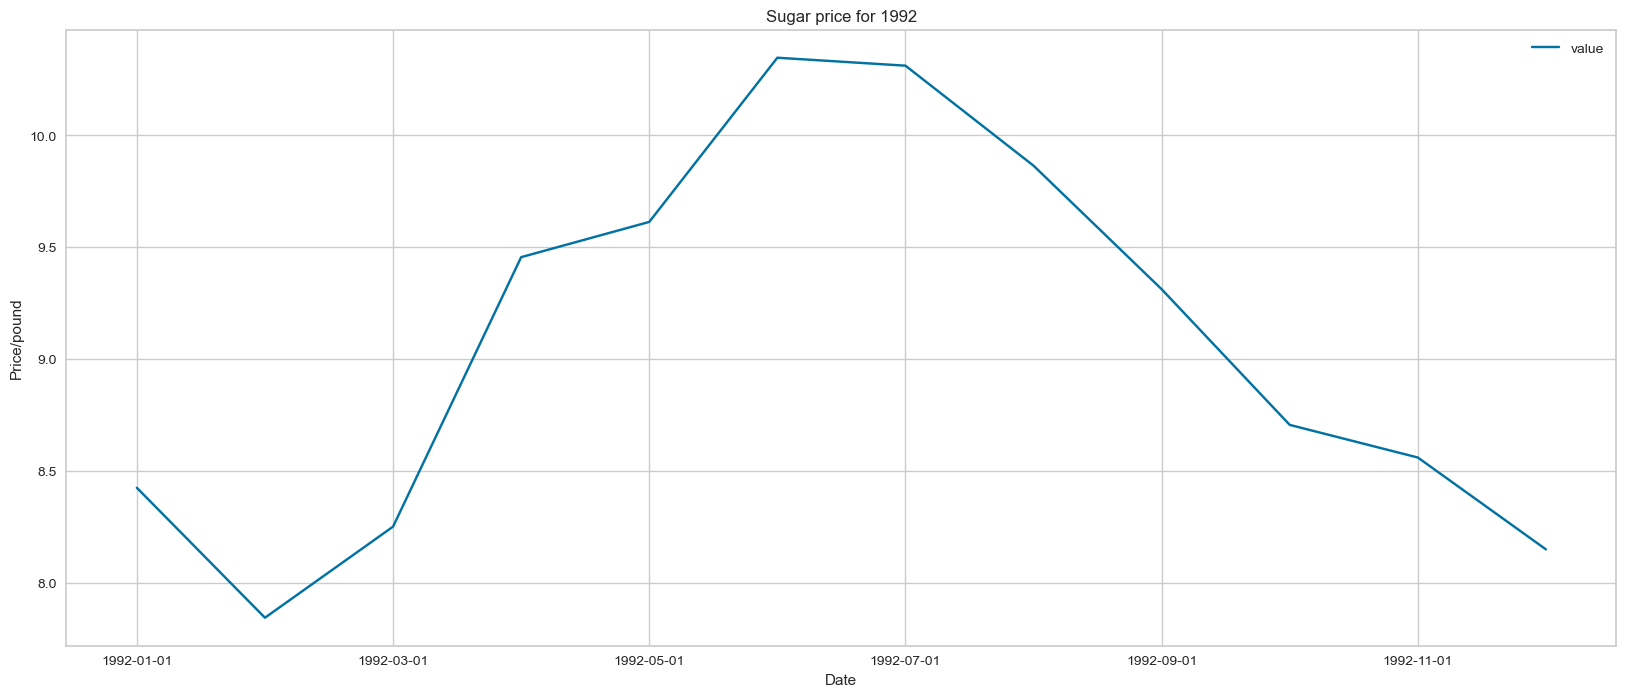

In [17]:
df.loc[(df.index >= '1992-01-01') & (df.index < '1993-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 1992')
plt.show()

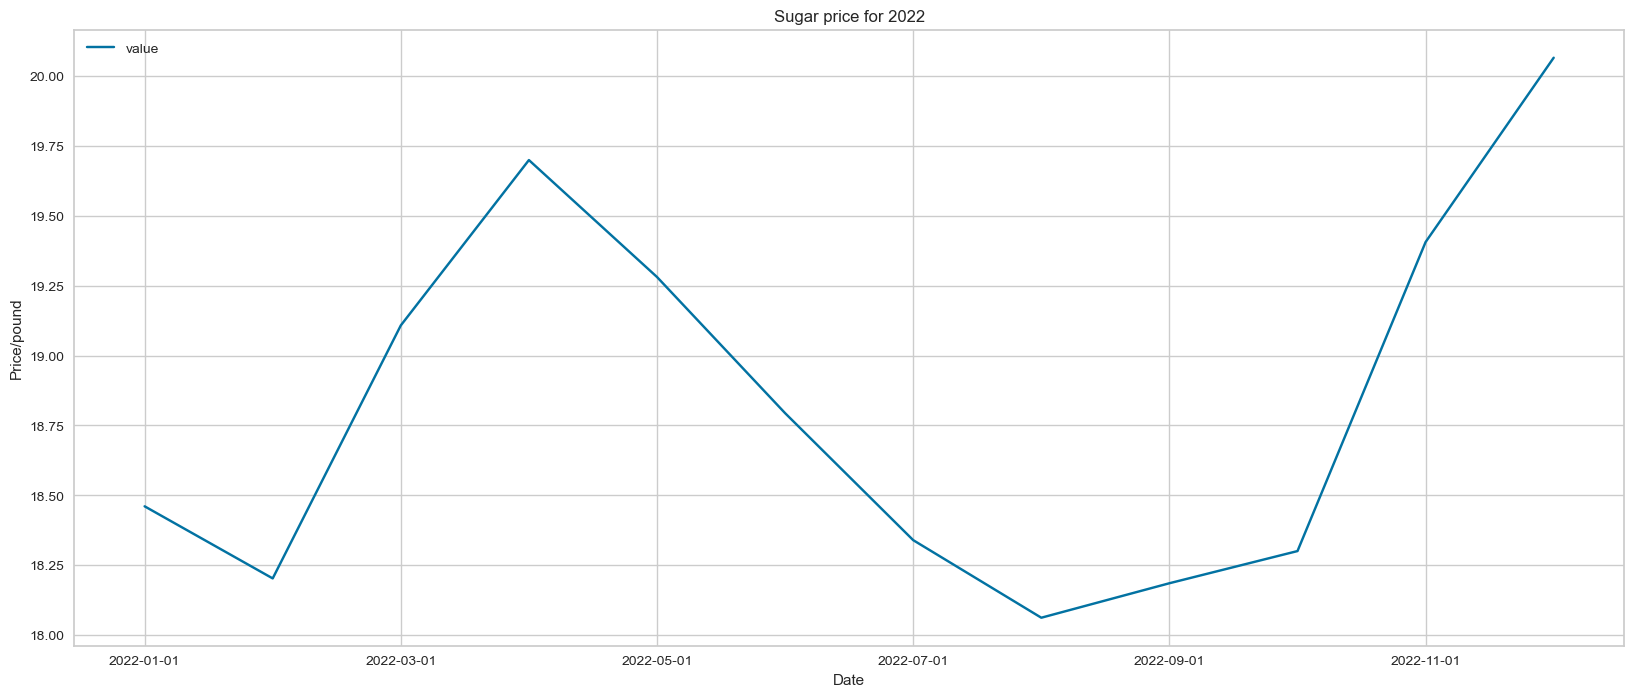

In [18]:
df.loc[(df.index >= '2022-01-01') & (df.index < '2023-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 2022')
plt.show()

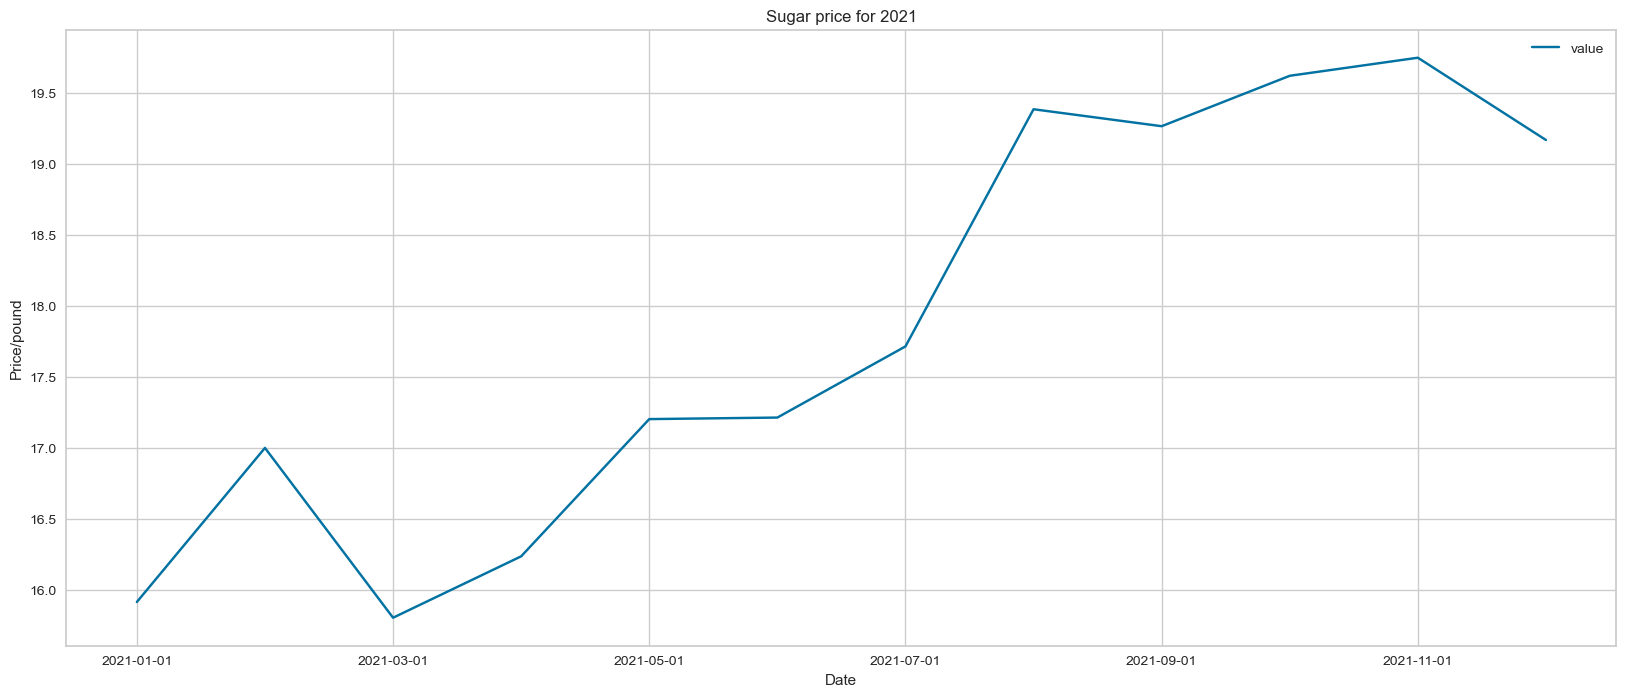

In [18]:
df.loc[(df.index >= '2021-01-01') & (df.index < '2022-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 2021')
plt.show()

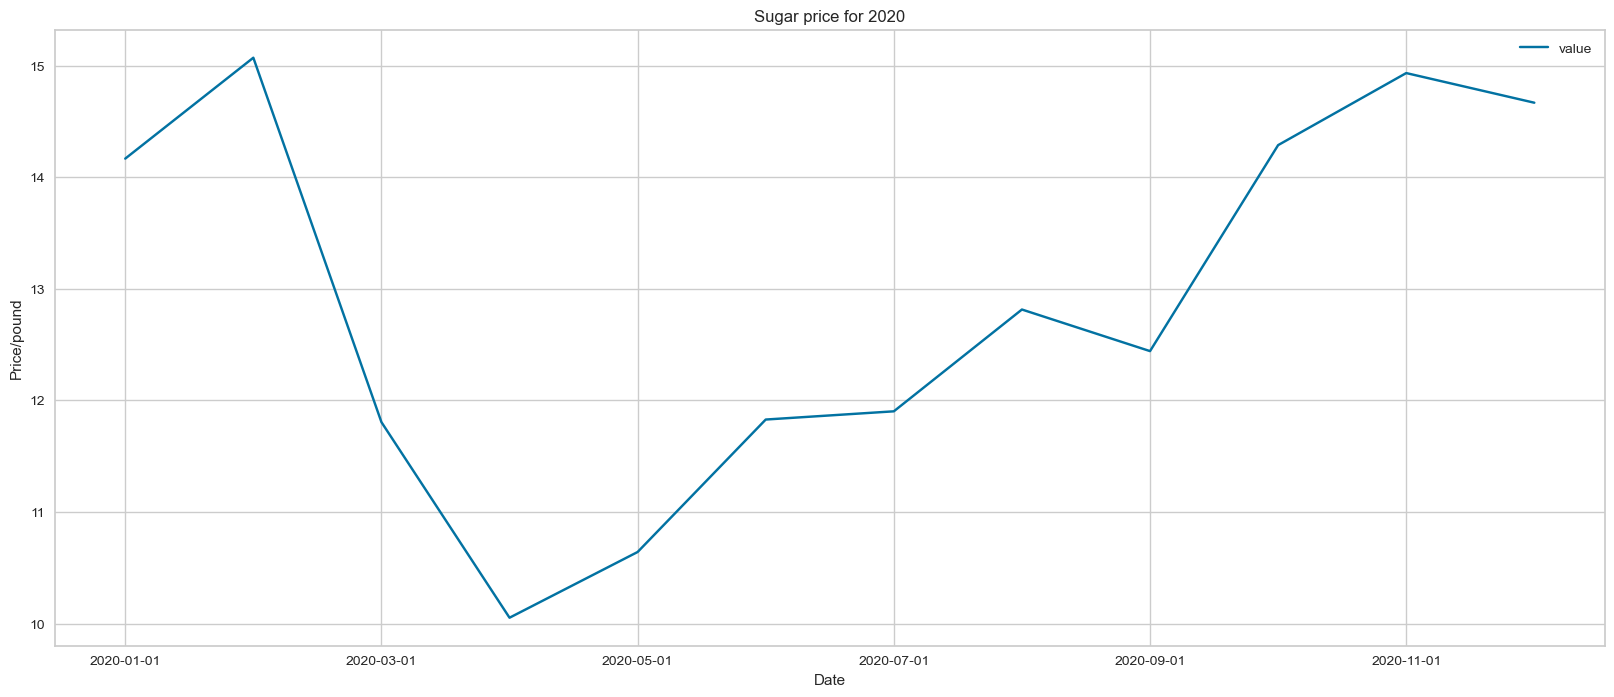

In [19]:
df.loc[(df.index >= '2020-01-01') & (df.index < '2021-01-01')].plot(figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Price/pound')
plt.title('Sugar price for 2020')
plt.show()

The price os sugar is very variable, there are no apparent seasons or trends. The price has only increased by 5 units since 1990, with a highest recorded price of about 30. 

# 5. Creation of some features

Create some lag features (shift the dataframe values by 1,2,3,6,12 months), and we will use these values to predict future prices

In [20]:
lags = (1,2,3,6,12)

df = df.assign(**{f'{col} (t-{lag})':df[col].shift(lag) for lag in lags for col in df})

In [21]:
df.rename(columns={'value (t-1)': '1M_lag', 'value (t-2)': '2M_lag','value (t-3)': '3M_lag', 'value (t-6)': '6M_lag','value (t-12)': '1Y_lag'}, inplace=True)

In [22]:
print(df)

                value     1M_lag     2M_lag     3M_lag     6M_lag     1Y_lag
date                                                                        
1990-01-01  14.200001        NaN        NaN        NaN        NaN        NaN
1990-02-01  14.650002  14.200001        NaN        NaN        NaN        NaN
1990-03-01  15.310001  14.650002  14.200001        NaN        NaN        NaN
1990-04-01  15.240002  15.310001  14.650002  14.200001        NaN        NaN
1990-05-01  14.619999  15.240002  15.310001  14.650002        NaN        NaN
...               ...        ...        ...        ...        ...        ...
2022-11-01  19.405909  18.300952  18.185909  18.062609  19.280909  19.746190
2022-12-01  20.065000  19.405909  18.300952  18.185909  18.794091  19.167273
2023-01-01  19.943182  20.065000  19.405909  18.300952  18.340000  18.461000
2023-02-01  21.403500  19.943182  20.065000  19.405909  18.062609  18.203158
2023-03-01  20.961739  21.403500  19.943182  20.065000  18.185909  19.107826

Worked as intended

# Train/Test split

In [23]:
df.dropna(axis=0, inplace=True)

In [24]:
print(len(df))

387


we have 387 values, split the data roughly 80:20, or into values before 2016 and values after&including 2017

In [25]:
train = df.loc[df.index < '2016-01-01']
test = df.loc[df.index >= '2017-01-01']

In [26]:
x_train = train.drop('value', axis=1)
y_train = train[['value']]

x_test = test.drop('value', axis=1)
y_test = test['value']

In [27]:
print(len(x_train) == len(y_train))
print(len(x_test) == len(y_test))

True
True


# Model tuning

In [28]:
def algorithm_optimisation(x_train, x_test, y_train, y_test, model, scoring_fit, param_grid):
    #Takes in pre-split data, model type, scoring to judge best parameters,
    #and a list of parameters to optimise for(These are tuning parameters for ML models)
    
    #Initiate the model with parameters
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, scoring=scoring_fit)
    
    #Fit the model with the training data and print the best parameters
    fitted_model = gs.fit(x_train, y_train)
    print(fitted_model.best_params_)
    
    
    #Initiate and fit a new model with the best parameters
    model = gs.best_estimator_
    model.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
    
    #Predict y-values
    y_predict = model.predict(x_test)
    
    
    #Find the mean square error, mean absolute error and r2 value and print
    mse_v = mse(y_test, y_predict)
    mae_v = mae(y_test, y_predict)
    r2_v = r2_score(y_test, y_predict)
    
    
    print("R-Squared: ", np.round(r2_v, 2))
    print("Mean Square Error: ", np.round(mse_v, 2))
    print("Mean Absolute Error: ", np.round(mae_v, 2))
    
    #Find the most importance features
    fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show()
    
    #Plot y_test vs y_predict
    plt.scatter(y_test, y_predict)
    plt.title('Y_test vs Y_predicted')
    plt.show()
    
    
    #Create dataframe of predicted vs actual values
    predict_actual = pd.DataFrame()
    predict_actual['Actual'] = y_test
    predict_actual['Prediction'] = y_predict
    print(predict_actual)
    
    #Find RMSE values for training and validation data, and plot them (Training and validation loss)
    results = model.evals_result()
    
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.axvline(21, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

{'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 350}
[0]	validation_0-rmse:7.09448	validation_1-rmse:8.03368
[100]	validation_0-rmse:0.83449	validation_1-rmse:1.29791
[200]	validation_0-rmse:0.72452	validation_1-rmse:1.25826
[300]	validation_0-rmse:0.66438	validation_1-rmse:1.25821
[349]	validation_0-rmse:0.64242	validation_1-rmse:1.24952
R-Squared:  0.85
Mean Square Error:  1.56
Mean Absolute Error:  1.03


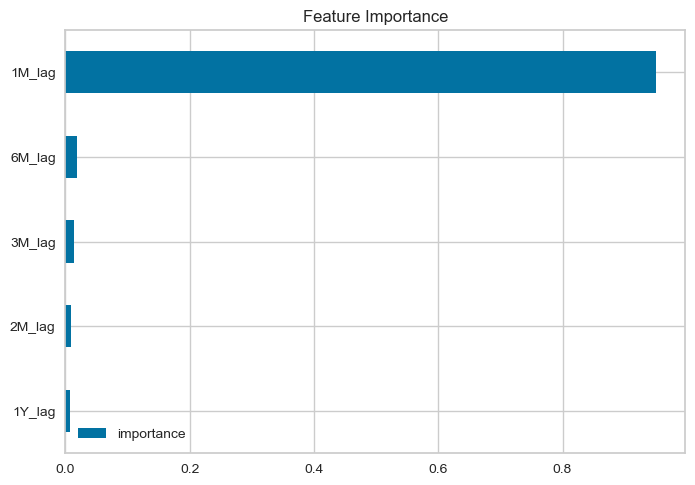

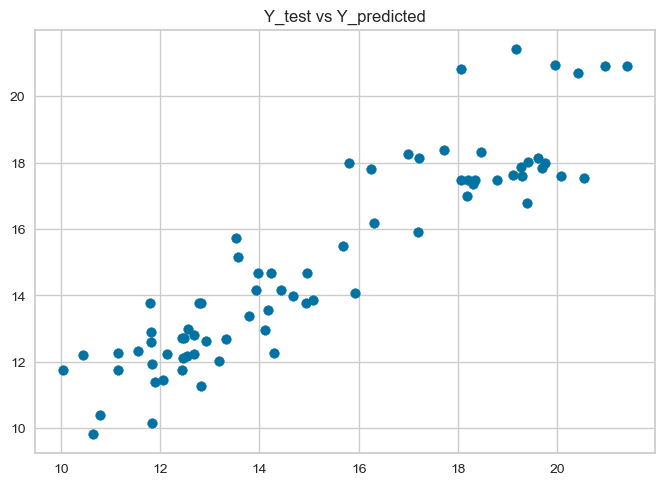

               Actual  Prediction
date                             
2017-01-01  20.537500   17.548813
2017-02-01  20.405789   20.706217
2017-03-01  18.059565   20.802622
2017-04-01  16.316842   16.191744
2017-05-01  15.689091   15.473511
...               ...         ...
2022-11-01  19.405909   18.015434
2022-12-01  20.065000   17.600624
2023-01-01  19.943182   20.934559
2023-02-01  21.403500   20.892242
2023-03-01  20.961739   20.892242

[75 rows x 2 columns]


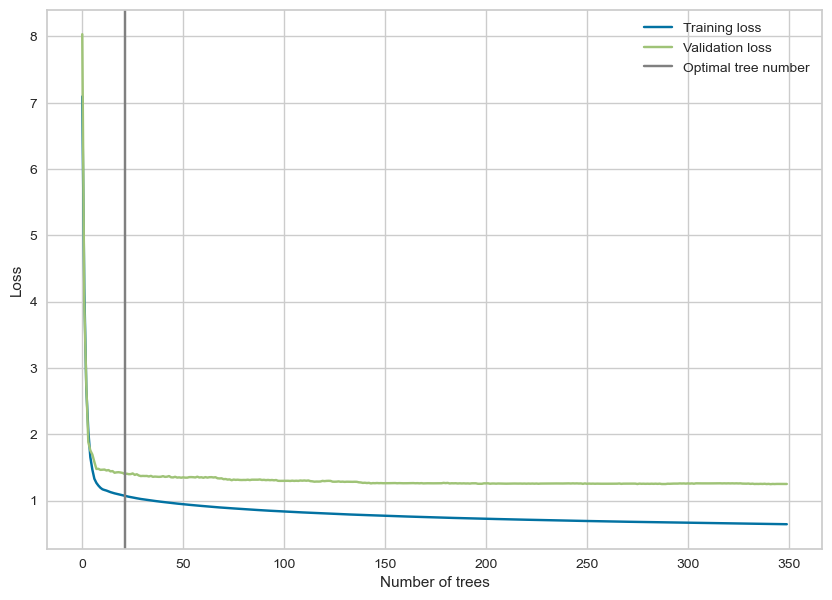

In [29]:
#Intiate the model
model = xgb.XGBRegressor()


#Parameters to change - increasing the learning rate & estimators step will increase the speed, but possibly underfit
learning_rate= np.arange(0, 1, 0.5)
depth = range(1,10,1)
estimators = range(50, 450, 100)


#Set up the parameter grid for tuning
param_grid = {
    'learning_rate': learning_rate, 'booster': ['gbtree'], 'max_depth': depth, 'n_estimators' : estimators}


#Run the algorith function
algorithm_optimisation(x_train, x_test, y_train, y_test, model, 'neg_mean_squared_error', param_grid)

{'booster': 'gblinear', 'learning_rate': 0.5, 'n_estimators': 350}
[0]	validation_0-rmse:3.46479	validation_1-rmse:2.41617
[100]	validation_0-rmse:1.12563	validation_1-rmse:0.98938
[200]	validation_0-rmse:1.05362	validation_1-rmse:0.96032
[300]	validation_0-rmse:1.02446	validation_1-rmse:0.95599
[349]	validation_0-rmse:1.01574	validation_1-rmse:0.95715
R-Squared:  0.91
Mean Square Error:  0.92
Mean Absolute Error:  0.72


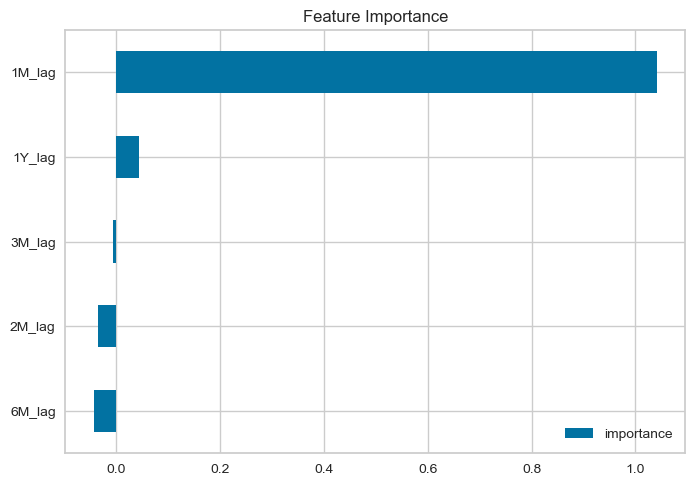

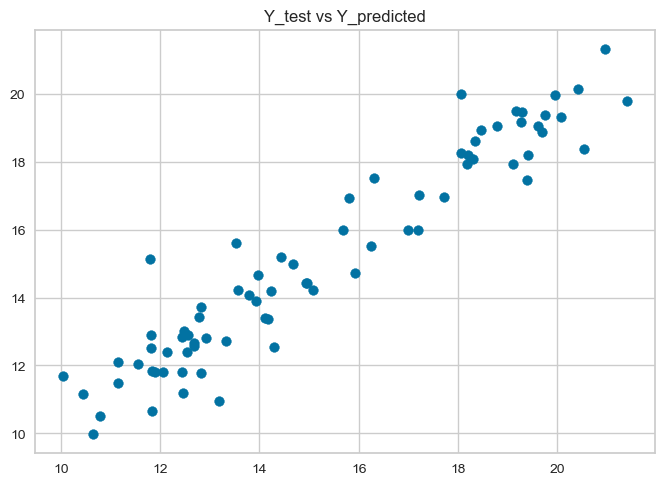

               Actual  Prediction
date                             
2017-01-01  20.537500   18.367273
2017-02-01  20.405789   20.135187
2017-03-01  18.059565   19.990826
2017-04-01  16.316842   17.506836
2017-05-01  15.689091   15.973522
...               ...         ...
2022-11-01  19.405909   18.208092
2022-12-01  20.065000   19.325003
2023-01-01  19.943182   19.946693
2023-02-01  21.403500   19.792917
2023-03-01  20.961739   21.314449

[75 rows x 2 columns]


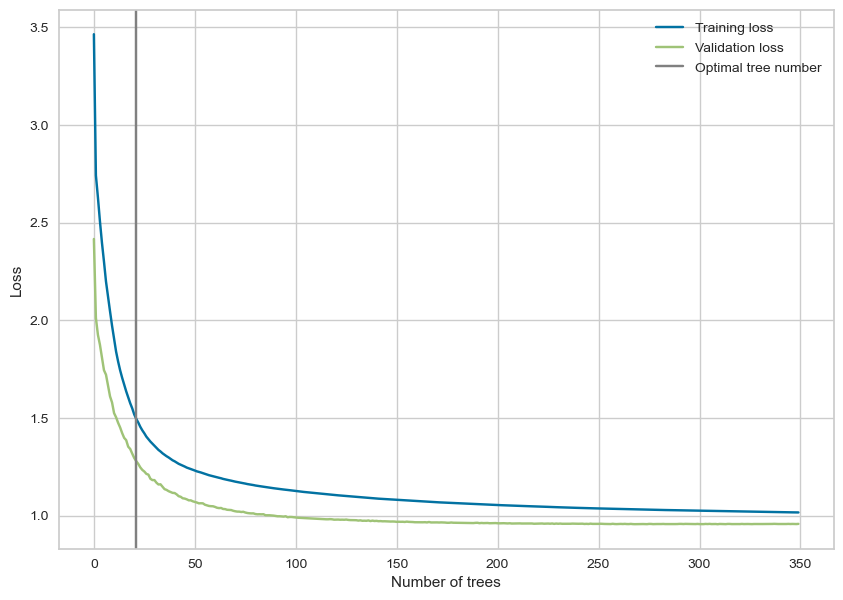

In [30]:
model = xgb.XGBRegressor()

learning_rate= np.arange(0, 1, 0.5)
estimators = range(50, 450, 100)



param_grid = {
    'learning_rate': learning_rate, 'booster': ['gblinear'], 'n_estimators' : estimators}

#Run the algorith function
algorithm_optimisation(x_train, x_test, y_train, y_test, model, 'neg_mean_squared_error', param_grid)

Assess the different models and decide on which one to take further

# Future Predictions

### Create a new df with all the values and retrain the model

In [31]:
df_fut = df

In [32]:
df_fut.dropna(axis=0, inplace=True)

In [33]:
x_train = df_fut.drop('value', axis=1)
y_train = df_fut[['value']]

x_test = df_fut.drop('value', axis=1)
y_test = df_fut['value']

In [34]:
def model_save(x_train, x_test, y_train, y_test, model, scoring_fit, param_grid):
    #Takes in pre-split data, model type, scoring to judge best parameters,
    #and a list of parameters to optimise for(These are tuning parameters for ML models)
    
    #Initiate the model with parameters
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, scoring=scoring_fit)
    
    #Fit the model with the training data and print the best parameters
    fitted_model = gs.fit(x_train, y_train)
    print(fitted_model.best_params_)
    
    
    #Initiate and fit a new model with the best parameters
    model = gs.best_estimator_
    model.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
    
    #Predict y-values
    y_predict = model.predict(x_test)
    
    
    mse_v = mse(y_test, y_predict)
    mae_v = mae(y_test, y_predict)
    r2_v = r2_score(y_test, y_predict)
    
    
    print("R-Squared: ", np.round(r2_v, 2))
    print("Mean Square Error: ", np.round(mse_v, 2))
    print("Mean Absolute Error: ", np.round(mae_v, 2))
    
    
    
    plt.scatter(y_test, y_predict)
    plt.title('Y_test vs Y_predicted')
    plt.show()
    
          
    predict_actual = pd.DataFrame()
    predict_actual['Actual'] = y_test
    predict_actual['Prediction'] = y_predict
    print(predict_actual)

    results = model.evals_result()
    
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.axvline(21, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
    #Perform the same model optimisation but this time save the model
    model.save_model('model_sugar.json')

{'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 450}
[0]	validation_0-rmse:7.33676	validation_1-rmse:7.33676
[100]	validation_0-rmse:0.88060	validation_1-rmse:0.88060
[200]	validation_0-rmse:0.79058	validation_1-rmse:0.79058
[300]	validation_0-rmse:0.73687	validation_1-rmse:0.73687
[400]	validation_0-rmse:0.69899	validation_1-rmse:0.69899
[449]	validation_0-rmse:0.68388	validation_1-rmse:0.68388
R-Squared:  0.98
Mean Square Error:  0.47
Mean Absolute Error:  0.51


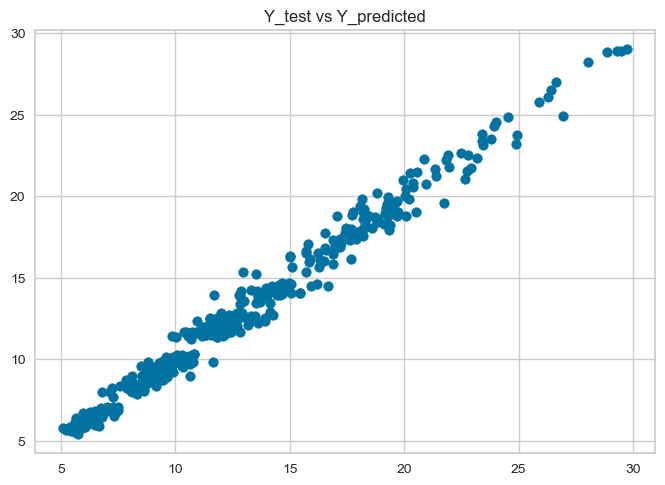

               Actual  Prediction
date                             
1991-01-01   8.799999    9.857216
1991-02-01   8.509998    8.564283
1991-03-01   9.139999    8.339033
1991-04-01   8.509998    9.585431
1991-05-01   7.588100    8.339033
...               ...         ...
2022-11-01  19.405909   19.054848
2022-12-01  20.065000   18.763391
2023-01-01  19.943182   20.959993
2023-02-01  21.403500   21.258032
2023-03-01  20.961739   20.750431

[387 rows x 2 columns]


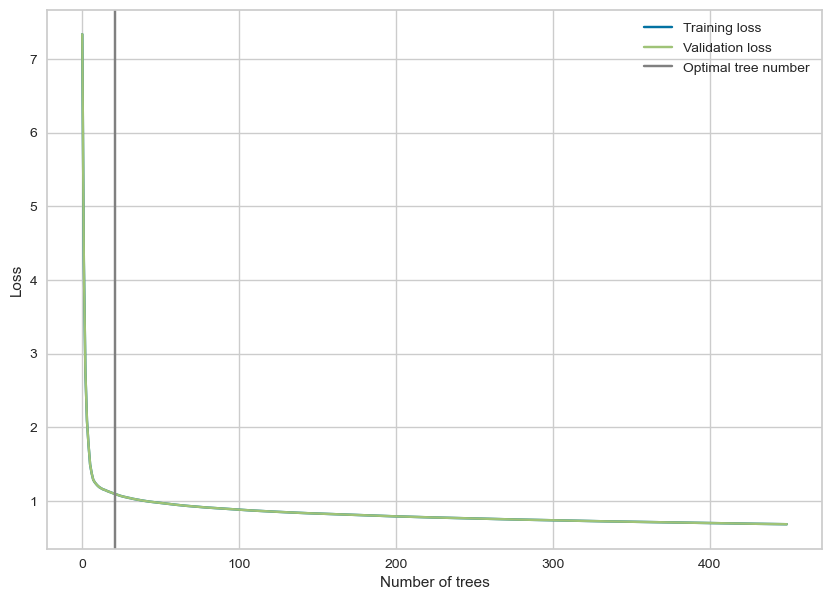

In [35]:
model = xgb.XGBRegressor()

learning_rate= np.arange(0, 1, 0.5)
depth = range(1,10,1)
estimators = range(50, 500, 50)



param_grid = {
    'learning_rate': learning_rate, 'booster': ['gbtree'], 'max_depth': depth, 'n_estimators' : estimators}

#Run the algorith function
model_save(x_train, x_test, y_train, y_test, model, 'neg_mean_squared_error', param_grid)

Now we have the model trained, reinitiate the model

In [36]:
model_predi = xgb.XGBRegressor()
model_predi.load_model('model_sugar.json')

Make a new df with the values we want to predict

Find the latest date in the df, add 3 months. Then make a new dataframe with the new dates. Concat the old dataframe (only values column) and the new dates

### Dateframe preparation

In [37]:
latest_date = df_fut.index.max()
start_date_future = pd.to_datetime(latest_date) + relativedelta(months=1)

In [38]:
future = pd.date_range(start_date_future, periods=3, freq='MS').strftime('%Y-%m-%d')
future_df = pd.DataFrame(index=future)

In [39]:
old_df = df['value']

In [40]:
df_and_future = pd.concat([old_df, future_df])

### Create new lag features

In [41]:
lags = (1,2,3,6,12)

df_and_future = df_and_future.assign(**{f'{col} (t-{lag})':df_and_future[col].shift(lag) for lag in lags for col in df_and_future})

df_and_future.rename(columns={'0 (t-1)': '1M_lag', '0 (t-2)': '2M_lag','0 (t-3)': '3M_lag', '0 (t-6)': '6M_lag','0 (t-12)': '1Y_lag'}, inplace=True)

df_and_future = df_and_future[12::]

### Predict the next three months

In [42]:
predict_next_month = df_and_future[:-2].copy()

In [43]:
features = ['1M_lag', '2M_lag', '3M_lag', '6M_lag', '1Y_lag']

In [44]:
predict_next_month['pred'] = model_predi.predict(predict_next_month[features])

month_1_predic = predict_next_month.iloc[-1]['pred']

In [45]:
df_and_future.iloc[[-2],[1]] = month_1_predic

predict_month_two = df_and_future[:-1].copy()

In [46]:
predict_month_two['pred'] = model_predi.predict(predict_month_two[features])

month_2_predic = predict_month_two.iloc[-1]['pred']

In [47]:
df_and_future.iloc[[-1],[1]] = month_2_predic
df_and_future.iloc[[-1],[2]] = month_1_predic

predict_month_three = df_and_future[::].copy()

In [48]:
predict_month_three['pred'] = model_predi.predict(predict_month_three[features])

month_3_predic = predict_month_three.iloc[-1]['pred']

In [49]:
print(month_1_predic, month_2_predic, month_3_predic)

20.74919319152832 20.02121353149414 20.065961837768555
